In [1]:
import os
from glob import glob

import dask.bag as db
#import dask.dataframe as dd
import xarray as xr
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from mitequinox.utils import *

#root_dir = '/home1/datawork/xyu/Drifters/'
#root_dir = '/Users/aponte/data/drifters/'
#data_dir = root_dir+'drifter_data_v1.02/'
data_dir = '/home/mp/pontea/scratch/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, walltime='12:00:00', memory='10GB')
w = cluster.scale(40)
#w = cluster.scale(5) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [5]:
client

Client Scheduler: tcp://10.135.39.59:60192 Dashboard: http://10.135.39.59:8787/status,Cluster Workers: 40 Cores: 40 Memory: 400.00 GB


In [16]:
#client.close()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


---
## utils

In [6]:
RADIUS_EARTH = 6378.0
deg2rad = np.pi / 180.
def haversine(lon1, lat1, lon2, lat2):
    """Computes the Haversine distance in kilometres between two points
    :param x: first point or points as array, each as array of latitude, longitude in degrees
    :param y: second point or points as array, each as array of latitude, longitude in degrees
    :return: distance between the two points in kilometres
    """
    llat1 = lat1 * deg2rad
    llat2 = lat2 * deg2rad
    llon1 = lon1 * deg2rad
    llon2 = lon2 * deg2rad
    arclen = 2 * np.arcsin(np.sqrt((np.sin((llat2 - llat1) / 2)) ** 2 +
                                   np.cos(llat1) * np.cos(llat2) * (np.sin((llon2 - llon1) / 2)) ** 2))
    return arclen * RADIUS_EARTH

---

## rewrite hourly data

In [6]:
def load_trajectory(ij, ncfile):
    ds = xr.open_dataset(ncfile).isel(TIME=slice(ij[0],ij[1]-1))
    #ds = ds.where( ~np.isinf(ds.LON), drop=False)
    df = ds.to_dataframe()
    id = int(df['ID'][0])
    df = df.drop(columns='ID')
    return df, id

def store(d):
    #d['ID'] = d.ID.values[0]
    #file = data_dir+'drifters/%d.p' %int(d.ID.values)
    file = data_dir+'drifters/%d.p' %d[1]
    pickle.dump( d, open( file, 'wb' ) , protocol=-1)

In [7]:
ncfile = data_dir+'driftertrajWMLE_1.02_block1.nc'

ds = xr.open_dataset(ncfile)
print(ds)
print(ds.note)

<xarray.Dataset>
Dimensions:  (TIME: 15230718)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2005-04-15T20:00:00 ... NaT
Data variables:
    ID       (TIME) float64 ...
    LAT      (TIME) float64 ...
    LON      (TIME) float64 ...
    U        (TIME) float64 ...
    V        (TIME) float64 ...
    LAT_ERR  (TIME) float64 ...
    LON_ERR  (TIME) float64 ...
    U_ERR    (TIME) float64 ...
    V_ERR    (TIME) float64 ...
    GAP      (TIME) timedelta64[ns] ...
    RMSGAP   (TIME) timedelta64[ns] ...
    DROGUE   (TIME) float64 ...
Attributes:
    title:        Hourly Argos-tracked drifters location and velocity estimat...
    description:  This is version 1.02, block 1 of the dataset. See http://ww...
    note:         For all variables of dimension TIME, interruptions in the e...
    creator:      Shane Elipot and Rick Lumpkin
    timestamp:    19-Dec-2018 13:25:49
For all variables of dimension TIME, interruptions in the estimation along a single trajectory are indicated by "Inf" v

In [8]:
inan = np.where(np.isnan(ds.LAT.values))[0]

In [9]:
b = (db.from_sequence([(i+1,j) for i,j in zip(np.hstack([-1,inan])[:-1],inan)], 
                      npartitions=1000)
     .map(load_trajectory, ncfile))
b.take(1)[0][0].head()

,LAT,LON,U,V,LAT_ERR,LON_ERR,U_ERR,V_ERR,GAP,RMSGAP,DROGUE
TIME,,,,,,,,,,,
2005-04-15 20:00:00,47.47501,312.05118,-0.1733,0.2009,0.01129,0.04254,0.0,0.0,00:54:43.200000,01:08:24,1.0
2005-04-15 21:00:00,47.46839,312.04200,-0.1616,-0.5554,0.00987,0.01140,0.0,0.0,01:04:48,00:58:12,1.0
2005-04-15 22:00:00,47.44858,312.03870,0.8653,-0.5284,0.00537,0.01501,0.0,0.0,00:33:07.200000,00:47:38.400000,1.0
2005-04-15 23:00:00,47.43282,312.07433,0.4313,-0.4776,0.00058,0.00803,0.0,0.0,00:28:48,00:49:33.600000,1.0
2005-04-16 00:00:00,47.41716,312.07013,0.0575,-0.4887,0.00049,0.00729,0.0,0.0,01:12:00,00:57:18,1.0


In [10]:
#d = b.take(6)[-1]
#ds, df = d[0], d[1]
#ds.where(np.isnan(ds.LON), drop=True).LON.values

In [11]:
#ds.LON.diff('TIME').plot()

In [ ]:
#b.take(10,compute=False).map(store).compute()
#b.map(store).compute()

In [12]:
for ifile in range(1,8):
    ncfile = data_dir+'driftertrajWMLE_1.02_block%d.nc' %ifile
    #
    ds = xr.open_dataset(ncfile)
    inan = np.where(np.isnan(ds.LAT.values))[0]
    #
    b = (db.from_sequence([(i+1,j) for i,j in zip(np.hstack([-1,inan])[:-1],inan)], 
                          npartitions=1000)
         .map(load_trajectory, ncfile))
    b.map(store).compute()
    print(ncfile)

/home/mp/pontea/scratch/driftertrajWMLE_1.02_block1.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block2.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block3.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block4.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block5.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block6.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block7.nc


In [12]:
cluster.close()

---

## reload as dask bag

In [30]:
#files = glob('data/*.nc')
files = glob(data_dir+'drifters/*.p')
files = [f for f in files if 'pairs' not in f]
print(len(files))

12287


In [14]:
#b = db.from_sequence(files).map(lambda f: xr.open_dataset(f))
b = db.from_sequence(files).map(lambda f: pickle.load(open(f, 'rb')))
b.take(1)

((                          LAT        LON       U       V  LAT_ERR  LON_ERR  \
  TIME                                                                         
  2008-01-13 11:00:00 -60.68735  301.60824  0.1315 -0.0584  0.00148  0.00419   
  2008-01-13 12:00:00 -60.68950  301.61580  0.1436 -0.0528  0.00055  0.00807   
  2008-01-13 13:00:00 -60.69022  301.63344  0.0206  0.0356  0.00123  0.00758   
  2008-01-13 14:00:00 -60.68731  301.63491  0.0302  0.1562  0.00144  0.00202   
  2008-01-13 15:00:00 -60.68167  301.63617  0.0087  0.1713  0.00251  0.00324   
  2008-01-13 16:00:00 -60.67903  301.62919 -0.1086  0.0199  0.00235  0.00166   
  2008-01-13 17:00:00 -60.67980  301.62226 -0.1148 -0.0658  0.00197  0.00082   
  2008-01-13 18:00:00 -60.68275  301.61476 -0.1145 -0.0647  0.00153  0.00066   
  2008-01-13 19:00:00 -60.68499  301.60785 -0.0949 -0.0693  0.00145  0.00120   
  2008-01-13 20:00:00 -60.68668  301.60128 -0.0929 -0.0952  0.00197  0.00123   
  2008-01-13 21:00:00 -60.69481  301.602

In [25]:
def cross(d1, iD):
    D = [pickle.load(open(f, 'rb')) for f in files[iD]]
    out = []
    for d in D:
        d2 = d[0]
        try:
            df = d1[0].join(d2, how='inner',lsuffix='_l',rsuffix='_r')
            # groupby block of time and average
            #dj = dj.groupby(pd.Grouper(freq='10D'))
            #dj = dj.resample('10D').mean()
            if not df.empty:
                # compute distance
                df['r'] = haversine(df['LON_l'],df['LAT_l'], 
                                    df['LON_r'],df['LAT_r'])
                if not df[df['r']<300].empty:
                    out.append([d[1],d1[1]])
        except:
            out.append([d[1],d1[1],'error'])
    if out:
        return out

In [19]:
Nc=10
i=0
D = [pickle.load(open(f, 'rb')) for f in files[i:min(i+Nc,len(files))]]
iD = slice(i, min(i+Nc,len(files)))

In [10]:
b = ( db.from_sequence(files[i+1:], npartitions=1000)
          .map(lambda f: pickle.load(open(f, 'rb'))) )

In [11]:
%time p = b.map(cross, iD).compute()

In [14]:
pairs = [lp for lp in p if (lp is not None) and (lp[0]!=lp[1])]

In [16]:
def load_pair(p):
    d0 = pickle.load(open(data_dir+'drifters/%d.p'%p[0], 'rb'))
    d1 = pickle.load(open(data_dir+'drifters/%d.p'%p[1], 'rb'))
    d0,d1 = d0[0].align(d1[0], join='inner')
    # could convert to geopandas here
    return d0,d1

In [17]:
d0, d1 = load_pair(pairs[0])

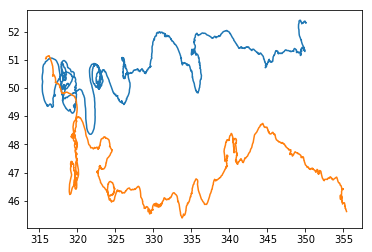

In [19]:
plt.plot(d0.LON,d0.LAT)
plt.plot(d1.LON,d1.LAT)

In [12]:
Nc = 10
i=0
iD = slice(i, min(i+Nc,len(files)))
%time b = ( db.from_sequence(files[:],npartitions=1000) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )
%time lb = b.map(cross, iD)
%time p = lb.compute()

CPU times: user 22.2 ms, sys: 2.02 ms, total: 24.2 ms
Wall time: 23.1 ms
CPU times: user 7.04 ms, sys: 1 ms, total: 8.04 ms
Wall time: 7.11 ms
CPU times: user 1min 16s, sys: 1.59 s, total: 1min 17s
Wall time: 1min 53s


In [13]:
Nc = 10
i=0
iD = slice(i, min(i+Nc,len(files)))
b = ( db.from_sequence(files[:],npartitions=100) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )
lb = b.map(cross, iD)
%time p = lb.compute()

CPU times: user 21.6 ms, sys: 29 µs, total: 21.6 ms
Wall time: 18.9 ms
CPU times: user 9.3 ms, sys: 1.04 ms, total: 10.3 ms
Wall time: 8.49 ms
CPU times: user 12.6 s, sys: 520 ms, total: 13.2 s
Wall time: 1min 1s


In [15]:
Nc = 100
iD = slice(i, min(i+Nc,len(files)))
b = ( db.from_sequence(files[:],npartitions=100) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )
lb = b.map(cross, iD)
%time p = lb.compute()

CPU times: user 85.1 ms, sys: 2.03 ms, total: 87.1 ms
Wall time: 83.1 ms
CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 10.7 ms
CPU times: user 1min 45s, sys: 4.03 s, total: 1min 49s
Wall time: 8min 27s


In [36]:
Nc=10
i=100
iD = slice(i, min(i+Nc,len(files)))
b = ( db.from_sequence(files[i+1:i+500], npartitions=100)
              .map(lambda f: pickle.load(open(f, 'rb'))) )
p = b.map(cross, iD).compute()

In [38]:
[llp for lp in p if lp is not None for llp in lp]

[[62201, 62201],
 [81975, 81975],
 [114572, 114572],
 [116362, 116362],
 [9712576, 9712576],
 [90173, 90173],
 [71270, 71270],
 [59748, 59748],
 [115021, 115021],
 [71270, 71272],
 [9712576, 9706571],
 [116362, 116041],
 [116362, 122557],
 [71270, 71288]]

In [41]:
# loop around groups of drifters and
# 730
Nc = 100
for i in range(730,len(files),Nc):
    
    file = data_dir+'drifters/pairs_%d.p' %i
    
    if not os.path.isfile(file):

        iD = slice(i, min(i+Nc,len(files)))
        #D = [pickle.load(open(f, 'rb')) for f in files[i:min(i+Nc,len(files))]]

        # load dask bag
        b = ( db.from_sequence(files[i+1:], npartitions=100)
              .map(lambda f: pickle.load(open(f, 'rb'))) )

        # cross data
        p = b.map(cross, iD).compute()
        p = [llp for lp in p if lp is not None for llp in lp]
        p = [lp for lp in p if (lp[0]!=lp[1])]
        #p = [lp for lp in p if (lp is not None) and (lp[0]!=lp[1])]

        pickle.dump( p, open( file, 'wb' ) , protocol=-1)
    
    print('%d / %d'%(i,len(files)))

730 / 12287
830 / 12287
930 / 12287
1030 / 12287
1130 / 12287
1230 / 12287
1330 / 12287
1430 / 12287
1530 / 12287
1630 / 12287
1730 / 12287
1830 / 12287
1930 / 12287
2030 / 12287
2130 / 12287
2230 / 12287
2330 / 12287
2430 / 12287
2530 / 12287
2630 / 12287
2730 / 12287
2830 / 12287
2930 / 12287
3030 / 12287
3130 / 12287
3230 / 12287
3330 / 12287
3430 / 12287
3530 / 12287
3630 / 12287
3730 / 12287
3830 / 12287
3930 / 12287
4030 / 12287
4130 / 12287
4230 / 12287
4330 / 12287
4430 / 12287
4530 / 12287
4630 / 12287
4730 / 12287
4830 / 12287
4930 / 12287
5030 / 12287
5130 / 12287
5230 / 12287
5330 / 12287
5430 / 12287
5530 / 12287
5630 / 12287
5730 / 12287
5830 / 12287
5930 / 12287
6030 / 12287
6130 / 12287
6230 / 12287
6330 / 12287
6430 / 12287
6530 / 12287
6630 / 12287
6730 / 12287
6830 / 12287
6930 / 12287
7030 / 12287
7130 / 12287
7230 / 12287
7330 / 12287
7430 / 12287
7530 / 12287
7630 / 12287
7730 / 12287
7830 / 12287
7930 / 12287
8030 / 12287
8130 / 12287
8230 / 12287
8330 / 12287
84

In [42]:
# concatenate all pairs


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


In [80]:
N=17
d1 = b.take(N)[0][0]
d1 = d1[~pd.isnull(d1.index)]
d2 = b.take(N)[N-1][0]
d2 = d2[~pd.isnull(d2.index)]
dj = d1.join(d2, how='inner',lsuffix='_l',rsuffix='_r')

In [81]:
if not dj.empty:
    print(dj)

                        LAT_l      LON_l     U_l     V_l  LAT_ERR_l  \
TIME                                                                  
2008-01-13 11:00:00 -60.68735  301.60824  0.1315 -0.0584    0.00148   
2008-01-13 12:00:00 -60.68950  301.61580  0.1436 -0.0528    0.00055   
2008-01-13 13:00:00 -60.69022  301.63344  0.0206  0.0356    0.00123   
2008-01-13 14:00:00 -60.68731  301.63491  0.0302  0.1562    0.00144   
2008-01-13 15:00:00 -60.68167  301.63617  0.0087  0.1713    0.00251   
2008-01-13 16:00:00 -60.67903  301.62919 -0.1086  0.0199    0.00235   
2008-01-13 17:00:00 -60.67980  301.62226 -0.1148 -0.0658    0.00197   
2008-01-13 18:00:00 -60.68275  301.61476 -0.1145 -0.0647    0.00153   
2008-01-13 19:00:00 -60.68499  301.60785 -0.0949 -0.0693    0.00145   
2008-01-13 20:00:00 -60.68668  301.60128 -0.0929 -0.0952    0.00197   
2008-01-13 21:00:00 -60.69481  301.60248  0.0359 -0.3005    0.00291   
2008-01-13 22:00:00 -60.70261  301.60681  0.1113 -0.1726    0.00352   
2008-0

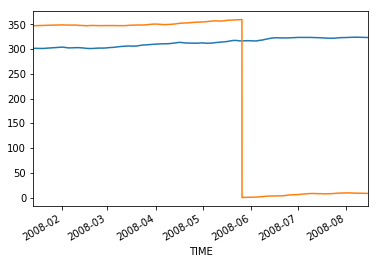

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
dj['LON_l'].plot(ax=ax)
dj['LON_r'].plot(ax=ax)

In [98]:
ds = b.take(2)[0]
ds = ds.where( ~np.isinf(ds.LON), drop=False)
print(ds.LON.values)
ds.LON.mean(dim='TIME')

[301.60824 301.6158  301.63344 ... 323.66552 323.67385 323.67344]


<xarray.DataArray 'LON' ()>
array(313.196905)

In [85]:
for i in b.take(2)[1].LON.values:
    print(i)

212.48165
212.48384
212.48201
212.48687
212.4779
212.48134
212.51681
212.51599
212.48756
212.48954
212.49159
212.49353
212.49876
212.51354
212.51506
212.51952
212.52272
212.52492
212.51921
212.51756
212.52396
212.51767
212.53014
212.55535
212.54915
212.54076
212.54408
212.54627
212.54916
212.55197
212.55478
212.5576
212.56045
212.56335
212.56635
212.56955
212.56469
212.55545
212.55063
212.56855
212.56603
212.55092
212.5513
212.55172
212.54975
212.54704
212.55216
212.55668
212.57256
212.56017
212.55916
212.55712
212.55566
212.55405
212.55367
212.5538
212.5538
212.55378
212.55382
212.5542
212.55386
212.5518
212.55333
212.55469
212.55786
212.55683
212.55328
212.56168
212.56154
212.55685
212.5405
212.54484
212.55908
212.55949
212.55965
212.5635
212.56713
212.57042
212.57363
212.57512
212.57254
212.56984
212.55963
212.55166
212.56355
212.56106
212.55817
212.55523
212.55522
212.55876
212.55462
212.55419
212.55365
212.55293
212.55185
212.55608
212.57636
212.55446
212.567
212.56734
212.57329
2

218.27862
218.2798
218.2731
218.25452
218.26286
218.25948
218.25877
218.2575
218.22534
218.25999
218.2592
218.25893
218.272
218.28725
218.30162
218.31303
218.32361
218.348
218.34495
218.35391
218.36341
218.369
218.35356
218.33782
218.32862
218.32372
218.31789
218.31595
218.34415
218.35134
218.35807
218.34528
218.35566
218.37506
218.39414
218.41237
218.43101
218.45257
218.43201
218.42973
218.43196
218.4538
218.44795
218.44279
218.43821
218.43406
218.42672
218.42739
218.4378
218.44642
218.42125
218.44749
218.46885
218.47699
218.4841
218.49108
218.49294
218.49829
218.51549
218.52427
218.53413
218.51164
218.5153
218.49348
218.49891
218.51992
218.52158
218.49235
218.49597
218.50691
218.52613
218.53919
218.54985
218.56019
218.54034
218.56493
218.56005
218.55743
218.55442
218.55123
218.5479
218.54434
218.54977
218.59334
218.58484
218.57653
218.56819
218.56163
218.55461
218.57525
218.58093
218.58668
218.59446
218.60119
218.60511
218.61689
218.62576
218.62529
218.62512
218.62528
218.62663
218.6

215.80494
215.82107
215.86128
215.85733
215.85306
215.84741
215.86497
215.86628
215.85377
215.86318
215.8637
215.8716
215.87987
215.89221
215.89651
215.89905
215.90111
215.90296
215.90771
215.92087
215.93373
215.94613
215.95786
215.97174
215.99535
216.00176
216.00748
216.02028
216.02036
216.0129
216.03979
216.03807
216.0521
216.06683
216.08093
216.08242
216.08695
216.11289
216.09248
216.08426
216.07382
216.07355
216.05906
216.04383
216.03201
216.02003
216.00541
215.99739
215.99127
215.98289
215.97158
215.9608
215.9437
215.94058
215.95377
215.93175
215.92711
215.92325
215.91964
215.9177
215.91339
215.90777
215.91045
215.89895
215.88482
215.87161
215.87011
215.86769
215.86475
215.86147
215.85787
215.85863
215.85639
215.84182
215.83965
215.85261
215.84664
215.84284
215.83613
215.82746
215.81811
215.80767
215.79838
215.79638
215.77946
215.77898
215.77862
215.77166
215.76501
215.75852
215.7521
215.74564
215.73802
215.68994
215.7265
215.72196
215.7162
215.72114
215.74123
215.75527
215.75442


216.47967
216.47621
216.46851
216.46671
216.46436
216.46152
216.45802
216.45464
216.45647
216.45139
216.44774
216.45069
216.449
216.43303
216.41584
216.45338
216.4209
216.42152
216.42266
216.42397
216.4268
216.43027
216.43422
216.44075
216.44774
216.45514
216.45984
216.46199
216.46433
216.46747
216.46773
216.47347
216.50321
216.48892
216.49826
216.51601
216.50955
216.51284
216.52249
216.52921
216.53386
216.53893
216.54436
216.55028
216.53679
216.53776
216.53752
216.53718
216.53423
216.51397
216.51586
216.50922
216.50161
216.494
216.48624
216.48405
216.49278
216.48638
216.47902
216.46763
216.4743
216.47298
216.47121
216.47227
216.47378
216.47516
216.47597
216.43253
216.43364
216.44606
216.46994
216.4654
216.46505
216.45478
216.47868
216.48891
216.48437
216.4919
216.50024
216.50657
216.52072
216.51296
216.51628
216.51702
216.51481
216.51293
216.511
216.50739
216.50462
216.5021
216.49949
216.49922
216.50504
216.51057
216.52062
216.56018
216.51625
216.50504
216.49801
216.49085
216.4834
216

220.30655
220.31641
220.3264
220.33607
220.34243
220.34676
220.33175
220.32884
220.33871
220.33642
220.33856
220.34315
220.34143
220.34046
220.32756
220.34135
220.34375
220.3334
220.33584
220.333
220.32985
220.32032
220.32257
220.32415
220.32613
220.328
220.32966
220.33258
220.33992
220.33754
220.32792
220.29541
220.32104
220.31182
220.30408
220.29776
220.29495
220.29168
220.2634
220.28542
220.28276
220.27733
220.2936
220.29811
220.27894
220.28917
220.29597
220.28982
220.27504
220.27256
220.27046
220.27162
220.27587
220.27541
220.26988
220.26821
220.26394
220.25906
220.2524
220.24065
220.21512
220.21608
220.21746
220.22156
220.22002
220.21563
220.21616
220.20847
220.19861
220.19383
220.18608
220.17728
220.16878
220.14199
220.13016
220.13176
220.13752
220.13282
220.12844
220.12522
220.12784
220.12411
220.11769
220.11147
220.10994
220.09784
220.09222
220.10203
220.10611
220.07921
220.11859
220.10833
220.06157
220.0553
220.0486
220.07104
220.05997
220.03905
220.03496
220.03159
220.03302
2

223.70009
223.68513
223.69776
223.69844
223.6971
223.68973
223.69028
223.69913
223.69239
223.68569
223.69621
223.70861
223.71146
223.71202
223.71345
223.71783
223.72179
223.70551
223.70323
223.73437
223.73986
223.74199
223.74831
223.75644
223.7622
223.76405
223.7673
223.77162
223.77151
223.75466
223.75634
223.78023
223.762
223.76516
223.76762
223.76996
223.77524
223.78739
223.79703
223.7989
223.8006
223.77722
223.77922
223.80789
223.80883
223.80436
223.79873
223.79908
223.79786
223.79819
223.80084
223.80063
223.79815
223.79438
223.79868
223.80625
223.81826
223.83306
223.83691
223.84236
223.83952
223.83865
223.83755
223.83638
223.8352
223.83402
223.83289
223.83187
223.8314
223.84243
223.82611
223.8221
223.81781
223.81381
223.79449
223.79783
223.77854
223.77123
223.78599
223.785
223.78989
223.79332
223.80894
223.80808
223.80512
223.78101
223.77936
223.79867
223.78724
223.75439
223.74558
223.73681
223.73699
223.73755
223.73211
223.72763
223.7237
223.72004
223.71711
223.72132
223.72182
223

226.10903
226.12214
226.12793
226.13279
226.13934
226.15262
226.16624
226.17916
226.18768
226.19602
226.20374
226.21075
226.21729
226.23307
226.24637
226.25854
226.27224
226.28196
226.28834
226.30821
226.31727
226.3176
226.32109
226.32388
226.33388
226.35845
226.3516
226.35633
226.36056
226.36444
226.37057
226.37463
226.37942
226.38428
226.38891
226.39333
226.39864
226.40902
226.42026
226.43589
226.44398
226.43153
226.43632
226.43977
226.44664
226.45302
226.45896
226.46422
226.47767
226.48725
226.4972
226.50704
226.50527
226.50854
226.53941
226.5355
226.49809
226.49279
226.48766
226.48256
226.47931
226.50042
226.50161
226.47637
226.47942
226.52268
226.4895
226.51062
226.50591
226.5035
226.50013
226.49724
226.50374
226.5081
226.5112
226.51535
226.52269
226.53274
226.53551
226.54112
226.54608
226.55071
226.55517
226.55953
226.56382
226.56841
226.57309
226.57776
226.58456
226.59259
226.59627
226.60256
226.61976
226.62261
226.61739
226.61994
226.63807
226.63574
226.6214
226.63822
226.65712

227.21564
227.22038
227.22513
227.22992
227.23434
227.23932
227.24851
227.28164
227.26398
227.27525
227.28974
227.30405
227.31814
227.33193
227.34535
227.36102
227.38097
227.38951
227.37998
227.37776
227.40902
227.4102
227.36497
227.37002
227.41231
227.41434
227.41829
227.42278
227.42026
227.41795
227.41576
227.41188
227.40796
227.40239
227.39626
227.39484
227.41047
227.39325
227.38389
227.37691
227.37213
227.36377
227.35697
227.35249
227.3509
227.34934
227.34893
227.34403
227.33337
227.33272
227.33137
227.33161
227.33808
227.34495
227.35338
227.35323
227.35628
227.36074
227.36585
227.36976
227.373
227.37033
227.36157
227.36283
227.37075
227.3584
227.3603
227.3734
227.36403
227.36436
227.37032
227.39474
227.40349
227.41049
227.40288
227.41085
227.41883
227.43533
227.46841
227.48076
227.48869
227.49959
227.5106
227.51566
227.52074
227.52486
227.52897
227.53298
227.53793
227.54428
227.55124
227.56144
227.54643
227.54034
227.54284
227.54867
227.56173
227.57456
227.58695
227.59802
227.6077

233.60148
233.60752
233.61494
233.62373
233.62932
233.62724
233.61221
233.60618
233.61615
233.62405
233.62296
233.63871
233.64693
233.64869
233.65475
233.66102
233.66698
233.67275
233.67838
233.68384
233.68889
233.6921
233.70069
233.70617
233.70701
233.71322
233.71631
233.71669
233.71787
233.72085
233.72351
233.73033
233.74436
233.7575
233.77379
233.79123
233.80848
233.82545
233.83695
233.8437
233.84557
233.8439
233.84432
233.84663
233.84931
233.85343
233.86755
233.87127
233.87258
233.88231
233.89181
233.9041
233.91553
233.92794
233.942
233.95572
233.96936
233.9831
233.99736
234.01228
234.03344
234.03897
234.04387
234.04892
234.05924
234.05927
234.06234
234.06594
234.0694
234.07378
234.08069
234.08793
234.08827
234.09629
234.09944
234.10486
234.11341
234.11733
234.12037
234.12297
234.12075
234.13359
234.11844
234.11859
234.12111
234.10298
234.09146
234.10634
234.10169
234.08659
234.08381
234.08135
234.07898
234.07817
234.07767
234.08416
234.08429
234.08271
234.07233
234.06584
234.06732

241.78288
241.79607
241.80854
241.82062
241.80717
241.80454
241.79726
241.79026
241.78372
241.7775
241.77128
241.76526
241.75966
241.74599
241.73407
241.73315
241.73503
241.74046
241.74385
241.74814
241.75567
241.76286
241.76948
241.77398
241.77748
241.79346
241.78484
241.79439
241.79643
241.79466
241.8087
241.80468
241.78764
241.78479
241.78203
241.77919
241.77644
241.77597
241.77503
241.77965
241.78527
241.78444
241.7844
241.78062
241.77583
241.7732
241.76927
241.76494
241.76123
241.75848
241.75387
241.74964
241.75808
241.73724
241.73414
241.73066
241.74804
241.73183
241.73205
241.73278
241.73378
241.73704
241.7381
241.73158
241.72852
241.7306
241.72228
241.7139
241.70505
241.69591
241.68648
241.67663
241.68233
241.67697
241.66671
241.66979
241.67848
241.66155
241.65783
241.66815
241.65604
241.64128
241.6149
241.60136
241.59079
241.58476
241.57456
241.56478
241.55392
241.5416
241.5217
241.51445
241.50028
241.48086
241.45722
241.42782
241.42655
241.41217
241.37942
241.36502
241.37914


241.39415
241.40023
241.40724
241.41454
241.42233
241.42587
241.42839
241.43163
241.4318
241.4318
241.43229
241.43019
241.42912
241.42873
241.42652
241.42455
241.42255
241.42466
241.41691
241.40393
241.38793
241.37333
241.38642
241.37262
241.36834
241.36804
241.37284
241.37725
241.38094
241.37832
241.3824
241.39492
241.40451
241.41293
241.41182
241.40817
241.40258
241.41057
241.40269
241.38309
241.37562
241.39729
241.35736
241.34773
241.3386
241.32222
241.30855
241.30558
241.31091
241.3154
241.31955
241.32352
241.32741
241.33124
241.33506
241.33919
241.34469
241.3504
241.34824
241.34895
241.34405
241.33487
241.31025
241.29496
241.2798
241.26154
241.2546
241.24535
241.20158
241.23468
241.19821
241.21666
241.20771
241.20333
241.19089
241.17714
241.17223
241.16756
241.17233
241.18863
241.18338
241.18348
241.18065
241.17502
241.17002
241.16518
241.15199
241.13973
241.1271
241.10266
241.10595
241.09546
241.08329
241.06889
241.0594
241.06647
241.06713
241.05614
241.05269
241.04992
241.04729


245.62043
245.62508
245.63136
245.6395
245.63654
245.63202
245.62704
245.62163
245.61604
245.61204
245.61563
245.60243
245.59894
245.59645
245.59347
245.59083
245.59134
245.58291
245.57057
245.55346
245.53026
245.51779
245.52672
245.51416
245.49449
245.48569
245.475
245.45277
245.45444
245.46045
245.45573
245.45541
245.45543
245.46273
245.47282
245.48267
245.46524
245.46171
245.45498
245.45428
245.45522
245.45533
245.45586
245.45646
245.45703
245.45992
245.48706
245.47216
245.47865
245.48231
245.4879
245.48808
245.51319
245.51401
245.49515
245.49502
245.49544
245.49382
245.49993
245.48613
245.4825
245.48669
245.49907
245.51333
245.52663
245.53594
245.54564
245.55587
245.56815
245.5779
245.58097
245.58271
245.5852
245.58816
245.59488
245.60214
245.61083
245.61598
245.62139
245.60791
245.60971
245.63545
245.63414
245.64797
245.66653
245.68348
245.69915
245.71114
245.67862
245.69122
245.70327
245.71509
245.72667
245.73927
245.75212
245.76322
245.77482
245.78539
245.79664
245.81333
245.829

253.77923
253.77457
253.77267
253.77304
253.76036
253.74245
253.73696
253.73685
253.73296
253.72372
253.71459
253.70628
253.69876
253.69121
253.68497
253.67719
253.66665
253.66275
253.66093
253.67023
253.6716
253.65665
253.6685
253.66896
253.66884
253.66882
253.66915
253.66443
253.65913
253.65284
253.64601
253.63263
253.63607
253.63885
253.64124
253.64341
253.64544
253.64735
253.64918
253.65094
253.65265
253.65431
253.65591
253.65791
253.66015
253.66114
253.66239
253.66391
253.68575
253.69155
253.69551
253.66911
253.66789
253.66694
253.66777
253.65828
253.6634
253.66606
253.66948
253.67311
253.67681
253.68052
253.68415
253.68726
253.71359
253.70138
253.69293
253.71366
253.71369
253.71324
253.71324
253.71294
253.71229
253.71273
253.71341
253.7476
253.71026
253.70793
253.70818
253.71087
253.71599
253.7169
253.71807
253.7192
253.72011
253.72068
253.72071
253.72751
253.73444
253.7415
253.74779
253.74877
253.74863
253.7499
253.75215
253.75424
253.75624
253.75818
253.76003
253.76173
253.767


In [77]:
def row(d):
    d0 = d.isel(TIME=0)
    d1 = d.isel(TIME=-1)
    dmean = d.mean(dim='TIME')
    return {'index': int(d.ID), 't0': d0.TIME.values, 't1': d1.TIME.values, 
            'lon0': d0.LON.values, 'lat0': d0.LAT.values,
            'lon1': d1.LON.values, 'lat1': d1.LAT.values, 
            'lonm': dmean.LON.values, 'latm': dmean.LAT.values}

In [78]:
df = b.map(row).to_dataframe()

In [79]:
df.head()

,index,lat0,lat1,latm,lon0,lon1,lonm,t0,t1
0,72225,-60.68735,-55.37916,inf,301.60824,323.67344,inf,2008-01-13 11:00:00,2008-08-15 01:00:00
1,139959,-38.35795,-33.17749,-34.802871778588106,212.48165,255.8217,230.78878613020854,2015-09-22 13:00:00,2018-07-05 11:00:00
2,103796,50.98836,52.30275,50.626032906868815,316.8033,350.06815,328.7902196875,2011-04-27 12:00:00,2012-01-21 19:00:00
3,36006,49.23945,47.925,inf,194.31873,220.93793,inf,2003-07-17 22:00:00,2004-10-01 00:00:00
4,90626,47.69302,47.49114,47.16451342971087,307.84693,308.3916,308.0917311714856,2009-05-06 23:00:00,2009-07-29 12:00:00


In [12]:
df = df.repartition(npartitions=1)
#df.npartitions

In [13]:
df.to_csv(data_dir+'drifters/bounds-*.csv', mode='w')

['/home/mp/pontea/scratch/drifters/bounds-0.csv']

In [91]:
df = dd.read_csv(data_dir+'drifters/bounds-*.csv')

In [8]:
#df.head()

In [36]:
df.repartitions(10000)

1

In [49]:
df = pd.read_csv(data_dir+'drifters/bounds-0.csv')
df.head()

,Unnamed: 0,index,lat0,lat1,lon0,lon1,t0,t1
0,0,72225,-60.68735,-55.37916,301.60824,323.67344,2008-01-13 11:00:00,2008-08-15 01:00:00
1,1,139959,-38.35795,-33.17749,212.48165,255.82170,2015-09-22 13:00:00,2018-07-05 11:00:00
2,2,103796,50.98836,52.30275,316.80330,350.06815,2011-04-27 12:00:00,2012-01-21 19:00:00
3,3,36006,49.23945,47.92500,194.31873,220.93793,2003-07-17 22:00:00,2004-10-01 00:00:00
4,4,90626,47.69302,47.49114,307.84693,308.39160,2009-05-06 23:00:00,2009-07-29 12:00:00


In [60]:
df = ( pd.read_csv(data_dir+'drifters/bounds-0.csv', parse_dates=[6,7])
       .set_index('index').drop(columns='Unnamed: 0') )
len(df)

12287

In [51]:
df.head()

,lat0,lat1,lon0,lon1,t0,t1
index,,,,,,
72225,-60.68735,-55.37916,301.60824,323.67344,2008-01-13 11:00:00,2008-08-15 01:00:00
139959,-38.35795,-33.17749,212.48165,255.82170,2015-09-22 13:00:00,2018-07-05 11:00:00
103796,50.98836,52.30275,316.80330,350.06815,2011-04-27 12:00:00,2012-01-21 19:00:00
36006,49.23945,47.92500,194.31873,220.93793,2003-07-17 22:00:00,2004-10-01 00:00:00
90626,47.69302,47.49114,307.84693,308.39160,2009-05-06 23:00:00,2009-07-29 12:00:00


In [55]:
#for id, row in df.iterrows():
#    print(type(row))b = 
b = db.from_sequence(df.iterrows())

In [56]:
b.take(1)

((72225, lat0               -60.6874
  lat1               -55.3792
  lon0                301.608
  lon1                323.673
  t0      2008-01-13 11:00:00
  t1      2008-08-15 01:00:00
  Name: 72225, dtype: object),)

In [40]:
item = b.take(1)
t0, t1 = item[0][1]['t0'], item[0][1]['t1']

In [69]:
import datetime
dt = datetime.timedelta(days=10)

In [73]:
def cross(item):
    id = item[0]
    t0 = item[1]['t0']
    t1 = item[1]['t1']
    #
    df = ( pd.read_csv(data_dir+'drifters/bounds-0.csv', parse_dates=[6,7])
           .set_index('index').drop(columns='Unnamed: 0') )
    df = df[~( (df.t1<t0+dt) | (df.t0>t1-dt) )]
    return len(df)

In [71]:
out = b.map(cross).compute()

(array([1.281e+03, 5.410e+03, 3.457e+03, 1.152e+03, 5.590e+02, 2.660e+02,
        1.060e+02, 5.300e+01, 2.000e+00, 1.000e+00]),
 array([1.0000e+00, 8.5230e+02, 1.7036e+03, 2.5549e+03, 3.4062e+03,
        4.2575e+03, 5.1088e+03, 5.9601e+03, 6.8114e+03, 7.6627e+03,
        8.5140e+03]),
 <a list of 10 Patch objects>)

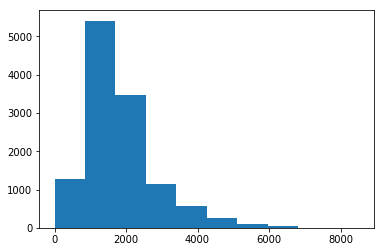

In [72]:
plt.hist(out)

---

## form bag of pairs

In [ ]:
#def ij(k):
#    i = n - 2 - np.int(np.sqrt(-8*k + 4*n*(n-1)-7)/2.0 - 0.5)
#    j = int(k + i + 1 - n*(n-1)/2 + (n-i)*((n-i)-1)/2)
#    return i, j

In [14]:
import itertools

In [ ]:
#b = (db.from_sequence(itertools.combinations(files, 2))
#    .map(lambda files: [xr.open_dataset(files[0]), xr.open_dataset(files[1])]))
b = (db.from_sequence(itertools.combinations(files, 2),npartitions=1000)
    .map(lambda files: [files[0], files[1]]))
b

In [121]:
b.take(1)

(['data/drifter_9729742.p', 'data/drifter_25763.p'],)

In [81]:
#from netCDF4 import Dataset

In [122]:
def flatten(p):
    ds0 = pickle.load(open(p[0], 'rb'))
    ds1 = pickle.load(open(p[1], 'rb'))
    #ds0 = xr.open_dataset(p[0], lock=False)
    #ds1 = xr.open_dataset(p[1], lock=False)
    #ds0 = Dataset(p[0])
    #ds1 = Dataset(p[1])
    return {
        'id0': int(ds0.ID.values),
        'id1': int(ds1.ID.values),
        '0_t0': ds0.isel(TIME=0).TIME.values,
        '0_t1': ds0.isel(TIME=-1).TIME.values,
        '1_t0': ds1.isel(TIME=0).TIME.values,
        '1_t1': ds1.isel(TIME=-1).TIME.values
    }
#        'id0': p[0],
#        'id1': p[1]
#        'p0_t0': p[0].isel(TIME=0).TIME.values,
#        'p0_t1': p[0].isel(TIME=-2).TIME.values,
#        'p1_t0': p[1].isel(TIME=0).TIME.values,
#        'p1_t1': p[1].isel(TIME=-2).TIME.values
b.map(flatten).take(1)

({'id0': 9729742,
  'id1': 25763,
  '0_t0': numpy.datetime64('1998-02-06T05:00:00.000000000'),
  '0_t1': numpy.datetime64('2001-02-15T16:00:00.000000000'),
  '1_t0': numpy.datetime64('2001-03-30T03:00:00.000000000'),
  '1_t1': numpy.datetime64('2004-11-07T17:00:00.000000000')},)

In [123]:
df = b.map(flatten).to_dataframe()

In [124]:
df.head()

,0_t0,0_t1,1_t0,1_t1,id0,id1
0,1998-02-06 05:00:00,2001-02-15 16:00:00,2001-03-30 03:00:00,2004-11-07 17:00:00,9729742,25763
1,1998-02-06 05:00:00,2001-02-15 16:00:00,2002-04-01 01:00:00,2005-03-23 03:00:00,9729742,34160
2,1998-02-06 05:00:00,2001-02-15 16:00:00,2005-05-25 21:00:00,2005-10-12 23:00:00,9729742,2556428
3,1998-02-06 05:00:00,2001-02-15 16:00:00,2003-01-17 04:00:00,2005-01-15 13:00:00,9729742,36960
4,1998-02-06 05:00:00,2001-02-15 16:00:00,2002-05-01 10:00:00,2003-12-02 22:00:00,9729742,32042


In [125]:
print(df.npartitions)
#print(df.size)

1000


In [ ]:
#df.repartition(1000).to_csv('data/pairs-*.csv')
df.to_csv('data/pairs-*.csv', mode='w') # can be done

In [17]:
def time_overlap(p):
    #t0, t1 = p[0].TIME.values, p[1].TIME.values
    #return not ( (t0[0] < t1[-1]) or (t1[0] < t0[-1]) )
    return ( p[0][-4] == p[1][-4] )

In [18]:
b.filter(time_overlap).compute()

[['data/drifter_39131.nc', 'data/drifter_54231.nc'],
 ['data/drifter_39131.nc', 'data/drifter_54371.nc'],
 ['data/drifter_39131.nc', 'data/drifter_30461.nc'],
 ['data/drifter_39131.nc', 'data/drifter_2444161.nc'],
 ['data/drifter_39131.nc', 'data/drifter_12411.nc'],
 ['data/drifter_39131.nc', 'data/drifter_2339261.nc'],
 ['data/drifter_39131.nc', 'data/drifter_52251.nc'],
 ['data/drifter_39131.nc', 'data/drifter_2556791.nc'],
 ['data/drifter_39131.nc', 'data/drifter_52191.nc'],
 ['data/drifter_39131.nc', 'data/drifter_2659761.nc'],
 ['data/drifter_39131.nc', 'data/drifter_2447611.nc'],
 ['data/drifter_39131.nc', 'data/drifter_41121.nc'],
 ['data/drifter_39131.nc', 'data/drifter_33191.nc'],
 ['data/drifter_39131.nc', 'data/drifter_32791.nc'],
 ['data/drifter_39131.nc', 'data/drifter_2444171.nc'],
 ['data/drifter_39131.nc', 'data/drifter_54221.nc'],
 ['data/drifter_39131.nc', 'data/drifter_9712541.nc'],
 ['data/drifter_39131.nc', 'data/drifter_21711.nc'],
 ['data/drifter_39131.nc', 'data